## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Your code here - remember to use markdown cells for comments as well!


objective:
determine which aircraft are the lowest risk for the company to start this new business endevor
(of purchasing and operating airplanesfor commericial and private enterprises).

In [11]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go



In [12]:
## read the aviation data set
df = pd.read_csv('data/Aviation_Data.csv')

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_6638/1529684122.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Aviation_Data.csv')


In [13]:
## explore the dataset
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

In [15]:
# Exclude amateur built aircraft as these are difficult to evaluate
df = df[df['Amateur.Built'] != 'Yes']

# Include only personal and Commercial use as specified by the problem statement
df = df[df['Purpose.of.flight'].isin(['Commercial', 'Personal'])]


# Convert data types
df['Total.Fatal.Injuries'] = pd.to_numeric(df['Total.Fatal.Injuries'], errors='coerce')
df['Total.Serious.Injuries'] = pd.to_numeric(df['Total.Serious.Injuries'], errors='coerce')
df['Total.Minor.Injuries'] = pd.to_numeric(df['Total.Minor.Injuries'], errors='coerce')
df['Total.Uninjured'] = pd.to_numeric(df['Total.Uninjured'], errors='coerce')


# Exploratory Data Analysis

In [23]:

# Group data by the number of engines and sum each type of injury
grouped_by_num_engines = df.groupby('Number.of.Engines')[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']].sum().reset_index()

# Create the stacked bar chart for injuries
fig = go.Figure(data=[
    go.Bar(name='Fatal Injuries', x=grouped_by_num_engines['Number.of.Engines'], y=grouped_by_num_engines['Total.Fatal.Injuries']),
    go.Bar(name='Serious Injuries', x=grouped_by_num_engines['Number.of.Engines'], y=grouped_by_num_engines['Total.Serious.Injuries']),
    go.Bar(name='Minor Injuries', x=grouped_by_num_engines['Number.of.Engines'], y=grouped_by_num_engines['Total.Minor.Injuries'])
])

# Offset for the grouped bar for uninjured
engine_counts = grouped_by_num_engines['Number.of.Engines'].tolist()
offset_engine_counts = [x + 0.1 for x in engine_counts]  # Slight offset to separate bars

# Add the grouped bar for uninjured
fig.add_trace(go.Bar(name='Uninjured', x=offset_engine_counts, y=grouped_by_num_engines['Total.Uninjured'], marker_color='lightblue'))

# Update the layout to adjust the display mode
fig.update_layout(barmode='relative',  # 'relative' allows stacked and grouped bars together
                  title='Injury Types by Number of Engines',
                  xaxis_title='Number of Engines',
                  yaxis_title='Number of Incidents',
                  xaxis = dict(tickmode='array', tickvals=engine_counts + offset_engine_counts, ticktext=engine_counts))

# Display the figure
fig.show()

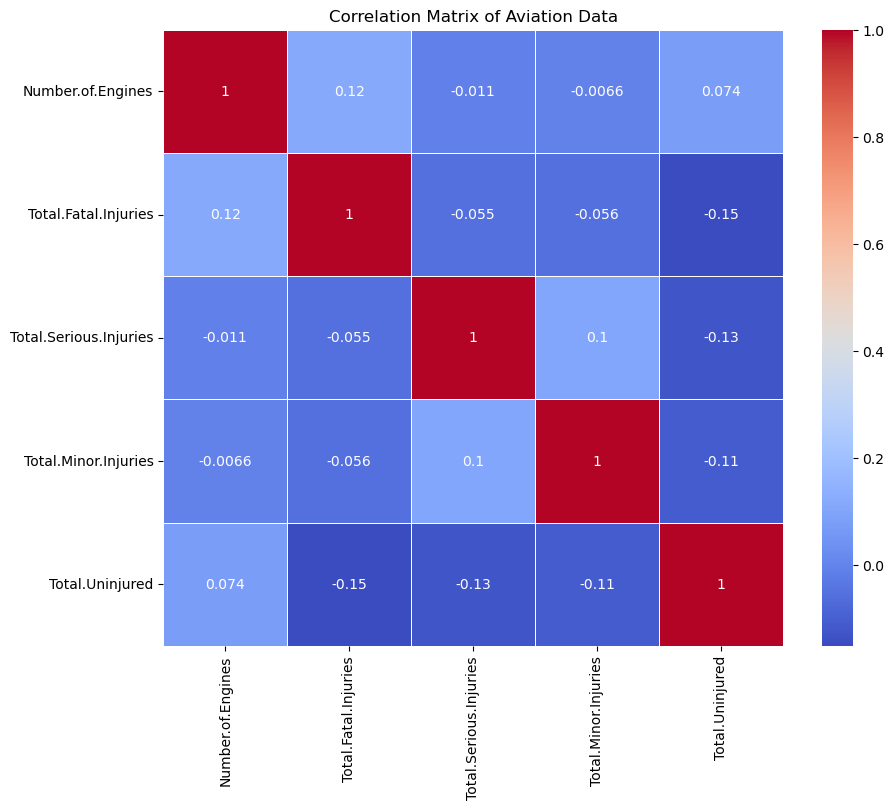

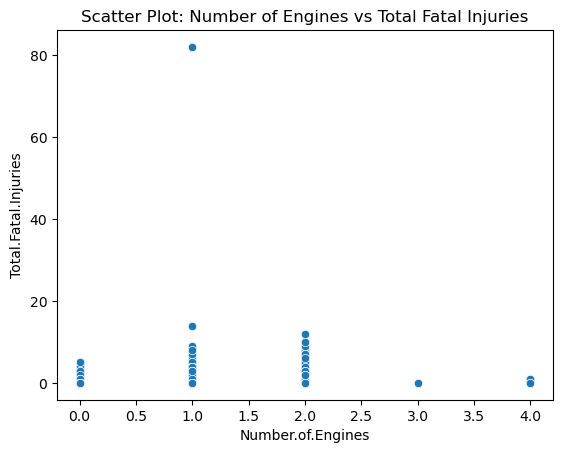

In [8]:
import seaborn as sns


# Select relevant columns for correlation analysis
relevant_columns = df[['Number.of.Engines', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 
                                  'Total.Minor.Injuries', 'Total.Uninjured']]
# Drop rows with any NaN values for accuracy in correlation
cleaned_data = relevant_columns.dropna()

# Compute the correlation matrix
correlation_matrix = cleaned_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Aviation Data')
plt.show()

# If you find an interesting correlation and want to explore further with scatter plots:
# For example, plotting Number of Engines vs. Total Fatal Injuries
sns.scatterplot(data=cleaned_data, x='Number.of.Engines', y='Total.Fatal.Injuries')
plt.title('Scatter Plot: Number of Engines vs Total Fatal Injuries')
plt.show()

In [31]:
## drop irrelevant columns, perform type conversions and clean data

# Convert 'Event.Date' to datetime and extract the year
df['Event.Date'] = pd.to_datetime(df['Event.Date'], errors='coerce')
df['Year'] = df['Event.Date'].dt.year

# Exclude amateur built aircraft
df = df[df['Amateur.Built'] != 'Yes']

# Include only personal and Commercial use as specified by the problem statement
df = df[df['Purpose.of.flight'].isin(['Commercial', 'Personal'])]


# drop irrelevant columns
relevant_columns = ['Year', 'Make', 'Model', 'Investigation.Type', 'Purpose.of.flight',
                    'Aircraft.damage', 'Total.Fatal.Injuries', 'Total.Serious.Injuries',
                    'Total.Minor.Injuries', 'Total.Uninjured']

#df = df[relevant_columns].dropna(subset=['Make', 'Model', 'Aircraft.damage'])

# Include only personal and Commercial use as specified by the problem statement
df = df[df['Purpose.of.flight'].isin(['Commercial', 'Personal'])]

df
# drop records for amateur built airplanes

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Year
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN,1948
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996,1962
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007,1974
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000,1977
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980,1979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90340,20221221106483,Accident,CEN23LA067,2022-12-21,"Auburn Hills, MI",United States,NaN,NaN,NaN,NaN,...,Pilot,0.0,1.0,0.0,0.0,NaN,NaN,NaN,22-12-2022,2022
90343,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022,2022
90345,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,...,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022,2022
90346,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,NaN,NaN,...,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2022


In [24]:
# group by aircraft make and model to analyze frequency and severity of incidents

grouped = df.groupby(['Make', 'Model']).agg({
    'Investigation.Type': 'count',
    'Total.Fatal.Injuries': 'sum',
    'Total.Serious.Injuries': 'sum',
    'Total.Minor.Injuries': 'sum',
    'Total.Uninjured': 'sum'
}).rename(columns={'Investigation.Type': 'Total.Incidents'})

grouped


,,Total.Incidents,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
Make,Model,,,,,
1200,G103,1,0.0,1.0,0.0,0.0
177MF LLC,PITTS MODEL 12,1,0.0,2.0,0.0,0.0
2021FX3 LLC,CCX-2000,1,0.0,0.0,0.0,2.0
A. Schleicher GMBH & Co.,ASW 27-18,1,0.0,1.0,0.0,0.0
AAA AIRCRAFT LLC,CCX-2000,1,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...
Zlin,Z143,1,0.0,0.0,0.0,1.0
Zlin Aviation,Savage Cub-S,1,0.0,0.0,0.0,1.0
Zlin Aviation S.r.o.,Savage,1,2.0,0.0,0.0,0.0


In [25]:
# create a risk score
grouped['Risk Score'] = grouped['Total.Incidents'] / grouped['Total.Uninjured']

# sort by risk to find the lowest risk aircraft
lowest_risk_aircraft = grouped.sort_values(by='Risk Score', ascending=True)

lowest_risk_aircraft

Total.Incidents  Total.Fatal.Injuries  \
Make                   Model                                                 
Boeing                 747-123                     1                   0.0   
Swearingen             SA-226TC                    1                   0.0   
MCDONNELL DOUGLAS      DC-9-87                     1                   0.0   
Gulfstream Aerospace   G-IV                        1                   0.0   
WINGTIP TO WINGTIP LLC PANZL S-330                 1                   0.0   
...                                              ...                   ...   
PILATUS AIRCRAFT LTD   PC-12/47E                   1                   8.0   
PIPER                  28-140                      1                   0.0   
                       AEROSTAR 600                1                   0.0   
PIASECKI/PIKE          PV-18                       1                   3.0   
1200                   G103                        1                   0.0   

                                     Total.Serious.Injuries  \
Make                   Model                                  
Boeing                 747-123                          0.0   
Swearingen             SA-226TC                         0.0   
MCDONNELL DOUGLAS      DC-9-87                          1.0   
Gulfstream Aerospace   G-IV                             0.0   
WINGTIP TO WINGTIP LLC PANZL S-330                      0.0   
...                                                     ...   
PILATUS AIRCRAFT LTD   PC-12/47E                        0.0   
PIPER                  28-140                           1.0   
                       AEROSTAR 600                     0.0   
PIASECKI/PIKE          PV-18                            0.0   
1200                   G103                             1.0   

                                     Total.Minor.Injuries  Total.Uninjured  \
Make                   Model                                                 
Boeing                 747-123                        0.0            412.0   
Swearingen             SA-226TC                       0.0             20.0   
MCDONNELL DOUGLAS      DC-9-87                        0.0             20.0   
Gulfstream Aerospace   G-IV                           0.0             13.0   
WINGTIP TO WINGTIP LLC PANZL S-330                    0.0             12.0   
...                                                   ...              ...   
PILATUS AIRCRAFT LTD   PC-12/47E                      0.0              0.0   
PIPER                  28-140                         1.0              0.0   
                       AEROSTAR 600                   1.0              0.0   
PIASECKI/PIKE          PV-18                          0.0              0.0   
1200                   G103                           0.0              0.0   

                                     Risk Score  
Make                   Model                     
Boeing                 747-123         0.002427  
Swearingen             SA-226TC        0.050000  
MCDONNELL DOUGLAS      DC-9-87         0.050000  
Gulfstream Aerospace   G-IV            0.076923  
WINGTIP TO WINGTIP LLC PANZL S-330     0.083333  
...                                         ...  
PILATUS AIRCRAFT LTD   PC-12/47E            inf  
PIPER                  28-140               inf  
                       AEROSTAR 600         inf  
PIASECKI/PIKE          PV-18                inf  
1200                   G103                 inf  

[6715 rows x 6 columns]

In [14]:
df.head()


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [16]:
df.describe()

,Event.Date,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
## Cleaning Data

# drop missing values
df.dropna(inplace=True)

In [ ]:
## EDA 

# Univariate Analysis -- anaylze single variables